In [52]:
def prior(thetas):
    # thetas : p x 1 vector.
    # Calculate the prior of thetas given the initilization distribution of theta (probability those theta are drawn        # from this distribution with means = 0 and variance 5.).
    prior_probability = multivariate_normal.pdf(thetas.T, mean = [0,0,0,0], cov = 5 ** 2 * np.eye(4))
    # return the prior probability.
    return prior_probability
    
# Computes the posterior probability of the given parameters theta and data.
def manual_log_like_normal(thetas, data):
    # Data_X[i] is (4,) meaning 1d vector with 4 elements. 
    # needs to be p x 1 to apply the likelihood formula.
    
    # Data_X[i] is 1d vector p x 1 vector
    # thetas is p x 1 vector
    # my data (X) is the design matrix n x p 
    # Data_Y is n x 1 vector with the observed output.
    Data_X = my_data[:,0:4]
    Data_Y = my_data[:,4]

    # Computes the likelihood of the data given thetas (new or current) according to exercise 1.
    likelihood = 0
    for i in range(len(Data_X)):
        likelihood += -np.exp(Data_X[i].T @ thetas) + (Data_Y[i] * Data_X[i].T @ thetas) - np.log(np.math.factorial(Data_Y[i]))

    # calculate the posterior by adding the log prior's probability as we have log in both likelihood and prior.
    posterior = likelihood + np.log(prior(thetas))
    return posterior

#Defines whether to accept or reject the new sample thetas.
def acceptance_rule(thetas_curr, thetas_new):
    # check if the posterior with theta new is bigger than current posterior (thetas_new > thetas_curr) we update theta.
    if thetas_new > thetas_curr:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(thetas_new-thetas_curr)))


In [53]:
def Gibbs_sampler(likelihood_computer, param_init, iterations, data, acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x, x_new): decides whether to accept or reject the new sample
    theta_curr = param_init
    accepted = []
    rejected = []
    # alpha, beta for the gibbs sampler for sigma^{2} to draw
    # samples from sigma^{2} ~ IG(alpha + 2, B + /thetas.T @ thetas)
    alpha = 0.1
    beta = 0.1
    sigmas = []
    # initialize an empty max numpy array for each iteration to save thetas to calculate posterior mean.
    theta_accepted = np.zeros(shape = (iterations, 4))
    for i in range(iterations):
        # 1st step : draw sigma from inverse distribution,
        # sample sigma from ~ IG(A+2, B+ (np.linalg.norm(thetas) ** 2) /2)
        inverse_gamma_sigma = invgamma.rvs \
            (a=alpha + 2, scale = beta + (theta_curr.T @ theta_curr) / 2)
        sigmas.append(inverse_gamma_sigma)
        # 2nd step : draw theta from normal distribution.
        # Then adjust the current theta by gaussian noise,
        # using sigma drawn from Inverse gamma distribution
        theta_new =  theta_curr + np.random.normal(0, inverse_gamma_sigma, (4,1))
        # 3rd step : calculate the posterior : prior + likelihood using theta and data.
        posterior_current_theta = likelihood_computer(theta_curr, data)
        posterior_new_theta = likelihood_computer(theta_new, data) 
        # 4th step : check whether you accept or not the proposed thetas 
        # based on the acceptance rule.
        if (acceptance_rule(posterior_current_theta, posterior_new_theta)):            
            theta_curr = theta_new
            # update the accepted means to calculate the monte carlo posterior mean afterwards.
            theta_accepted[i] = np.reshape(theta_curr, (4,))
            accepted.append(theta_new)
        else:
            theta_accepted[i] = np.reshape(theta_curr, (4,))
            rejected.append(theta_new)            
                
    return np.array(accepted), np.array(rejected), theta_accepted, sigmas 

In [54]:
import pandas as pd 
import numpy as np
from scipy.stats import multivariate_normal, invgamma
import matplotlib.pyplot as plt
from colour import Color

from numpy import genfromtxt
my_data = genfromtxt('dataexercise2.csv', delimiter=',')
# drop first line of nan's (x1, x2..,y)
my_data = np.delete(my_data, (0), axis=0)
np.set_printoptions(suppress=True) #prevent numpy exponential 
#notation on print, default False.
std_dev = 5
# iterations to reach the minimum.
iterations = 5000
# draw random thetas from normal distribution to initialize thetas.
thetas = np.random.normal(0, 5, (4, 1))
# thetas using multivariate insstead.
# thetas = np.random.multivariate_normal([0,0,0,0], 5 * np.eye(4))
accepted, rejected, means_accepted, sigmas = Gibbs_sampler(manual_log_like_normal, thetas, iterations, my_data, acceptance_rule)

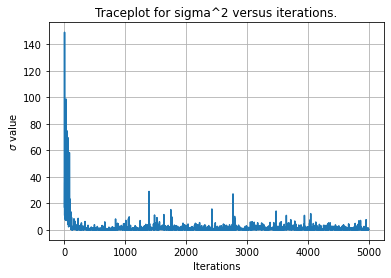

In [59]:
# create traceplot 

fig, ax = plt.subplots()

ax.plot(range(len(sigmas)), sigmas)
ax.set(xlabel='Iterations', ylabel='$\sigma$ value',
       title='Traceplot for sigma^2 versus iterations.')
ax.grid()

fig.savefig("gibbs_sigma.png")
plt.show()